In [ ]:
import sys
import os

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from peft import PeftModel

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
# project imports
try:
    import ft_utils
    import utils_dora
    from commonsense.commonsense_evaluate import generate_prompt
    from mas_llama_impl.modeling_mas_llama import MasLlamaForCausalLM
except Exception as e:
    print(f'ERROR: could not import project modules! make sure you are running this script from the project root directory and that all imported files are present.')
    raise e

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

DEBUG_FLAG = False

if sys.platform == 'darwin':  # check if platform is MAC OS
    print('Platform is MAC OS. Setting backend to DEBUG mode for FP16->FP32 conversion')
    DEBUG_FLAG = True  # this is due most macs not supporting FP16 operations

Using device: cpu
Platform is MAC OS. Setting backend to DEBUG mode for FP16->FP32 conversion


In [4]:
llama_base_model = 'meta-llama/Llama-3.2-1B'

# NOTE: make sure this folde is present and contains the checkpoint files 'adapter_model.safetensors' and 'adapter_config.json'
path_lora_weights_causal = 'trained_models_and_results/Llama-3.2-1B_epoch3'
path_lora_weights_mas = 'trained_models_and_results/Llama-3.2-1B_epoch3_MAS'

# make sure the weights are present
if not os.path.exists(path_lora_weights_causal):
    print(f'ERROR: could not find causal model weights at {path_lora_weights_causal}')
    sys.exit(1)

if not os.path.exists(path_lora_weights_mas):
    print(f'ERROR: could not find mas model weights at {path_lora_weights_mas}')
    sys.exit(1)

In [5]:
preferred_dtype = ft_utils.get_preferred_dtype_per_model(llama_base_model)
if DEBUG_FLAG:
    preferred_dtype = torch.float32
    print(f'Overriding preferred_dtype to torch.float32 due to DEBUG_FLAG')

tokenizer = AutoTokenizer.from_pretrained(llama_base_model)  # same as the original model
utils_dora.set_pad_token(tokenizer, model_name=llama_base_model)
model_MAS = MasLlamaForCausalLM.from_pretrained(llama_base_model,
                                                MAS_template='commonsense',  # important! this is the config that will identify the segments for MAS
                                                attn_implementation="eager",
                                                trust_remote_code=True,
                                                torch_dtype=preferred_dtype
                                                )

Overriding preferred_dtype to torch.float32 due to DEBUG_FLAG


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
You are using a model of type llama to instantiate a model of type mas_llama. This is not supported for all configurations of models and can yield errors.


Init MAS model with config.MAS_template: commonsense


In [ ]:
model_MAS = PeftModel.from_pretrained(model_MAS,
                                      path_lora_weights_mas,
                                      ).eval().requires_grad_(False).to(device)
model_MAS

In [ ]:
model_causal = AutoModelForCausalLM.from_pretrained(llama_base_model,
                                                    attn_implementation="eager",
                                                    trust_remote_code=True,
                                                    torch_dtype=preferred_dtype
                                                    )
model_causal = PeftModel.from_pretrained(model_causal,
                                            path_lora_weights_causal,
                                            ).eval().requires_grad_(False).to(device)

In [ ]:
prompt_data = {
    'instruction': 'Please answer with yes/no if the following statement is true or false: doing push ups is a good way to stay fit.',
    'input': '' # addiontal input, not mandatory
}
prompt = generate_prompt(instruction=prompt_data['instruction'],
                         input=prompt_data['input'])
inputs = tokenizer([prompt], return_tensors="pt", padding=True).to(device)
generation_config = GenerationConfig(
        temperature=0.1,
        top_p=0.75,
        top_k=40,
    )
MAX_NEW_TOKENS = 16

In [ ]:
generation_output_MAS = model_MAS.generate(
            # input_ids=input_ids,
            **inputs,  # adding input_ids and attention_mask (should not change anything)
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            output_attentions=True,
            # output_attentions=True,
            max_new_tokens=MAX_NEW_TOKENS,
        )
s = generation_output_MAS.sequences
outputs_MAS = tokenizer.batch_decode(s, skip_special_tokens=True)
print(f"Outputs by MAS: {outputs_MAS[0]}")
outputs_MAS_only_answer = [o.split("### Response:")[-1].strip() for o in outputs_MAS]
print('-'*77, f'\nMAS model answer (with input): "{outputs_MAS_only_answer[0]}"')

In [ ]:
generation_output_causal = model_causal.generate(
            **inputs,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            output_attentions=True,
            max_new_tokens=MAX_NEW_TOKENS,
        )
s = generation_output_causal.sequences
outputs_causal = tokenizer.batch_decode(s, skip_special_tokens=True)
print(f"Putputs by causal: {outputs_causal[0]}")
outputs_causal_only_answer = [o.split("### Response:")[-1].strip() for o in outputs_causal]
print('-'*77, f'\nCausal model answer (with input): "{outputs_causal_only_answer[0]}"')

In [11]:
# Explaining how the output looks like
attn_heads = generation_output_MAS.attentions
# attn_heads = generation_output_causal.attentions
print(len(attn_heads), len(attn_heads[0]))  # amount of generated tokens, amount of layers
print(attn_heads[0][0].shape) # batch size (1), amount of heads, amount of tokens, amount of tokens
print(attn_heads[1][0].shape) # for the second token and forward, the final attention maps output is 1 X amount of previous tokens ( a vector rather than a matrix)

6 16
torch.Size([1, 32, 55, 55])
torch.Size([1, 32, 1, 56])


In [22]:
# chose one of the following options which are nice to visualize

layer_index = 0
head_index = 25

# # another nice option
# layer_index = 10
# head_index = 23

batch_index = 0

In [23]:
def stack_attn_output_into_attn_map(attn_heads, layer_index=layer_index, head_index=head_index, batch_index=0):
    seq_final_lenght = attn_heads[-1][layer_index].shape[-1]
    # stack all generated attentions for the same head
    attn_maps = torch.zeros((seq_final_lenght, seq_final_lenght))
    prompt_length = attn_heads[0][layer_index][batch_index, head_index].shape[-1]
    attn_maps[:prompt_length, :prompt_length] = attn_heads[0][layer_index][batch_index, head_index]
    for decoding_step in range(seq_final_lenght - prompt_length):
        attn_maps[prompt_length + decoding_step, :prompt_length + decoding_step] = attn_heads[decoding_step + 1][0][batch_index, head_index, 0, :prompt_length + decoding_step]
    return attn_maps

attn_map_causal = stack_attn_output_into_attn_map(generation_output_causal.attentions)
attn_map_mas = stack_attn_output_into_attn_map(generation_output_MAS.attentions)

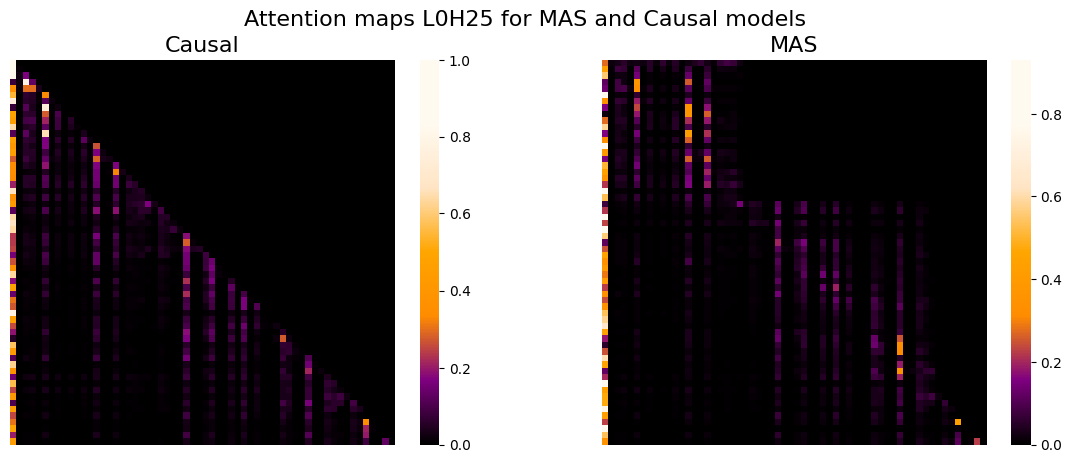

In [26]:
color_list = ['black', 'purple', 'darkorange', 'orange', 'bisque', 'floralwhite', 'floralwhite']
cmap_viz = LinearSegmentedColormap.from_list("",color_list)
# cmap_viz = 'viridis'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, curr_map, title in zip([ax1, ax2], [attn_map_causal, attn_map_mas], ['Causal', 'MAS']):
    sns.heatmap(curr_map.cpu().detach().numpy(), ax=ax,
                square=True,
                cmap=cmap_viz,
                xticklabels=False,
                yticklabels=False,
                cbar=True)
    ax.set_title(title, fontsize=16)
plt.suptitle(f'Attention maps L{layer_index}H{head_index} for MAS and Causal models', fontsize=16)
plt.show()